<a href="https://colab.research.google.com/github/AnushkaMishra29/Eurosat-tensorflow-/blob/master/eurosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
splits=('train[:80%]','train[80%:]')
(dataset_raw_train,dataset_raw_test),metadata=tfds.load(name='eurosat',
                                                        as_supervised=True,
                                                        split=splits,
                                                        with_info=True,
                                                        )

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteW0HX9S/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
     

In [ ]:
print(dataset_raw_train);
print(dataset_raw_test);

<DatasetV1Adapter shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
train_eg=0
for eg in dataset_raw_train:
  train_eg+=1
print(train_eg)
validation_eg=0
for eg in dataset_raw_test:
  validation_eg+=1
print(validation_eg)

21600
5400


In [ ]:
get_label_name=metadata.features['label'].int2str

In [ ]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));
print(get_label_name(3));
print(get_label_name(4));
print(get_label_name(5));
print(get_label_name(6));
print(get_label_name(7));
print(get_label_name(8));
print(get_label_name(9));

AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake


In [ ]:
image_size=metadata.features['image'].shape[0]

In [ ]:
print(image_size)

64


In [ ]:
image_shape = metadata.features['image'].shape
print(image_shape)

(64, 64, 3)


In [ ]:
num_class=metadata.features['label'].num_classes
print(num_class)

10


In [ ]:
def preprocess(image,label):
  image=tf.cast(image,tf.float32)
  image=image/255
  image=tf.image.resize(image,[image_size,image_size])
  return image, label

In [ ]:
training_data=dataset_raw_train.map(preprocess)
validation_data=dataset_raw_test.map(preprocess)

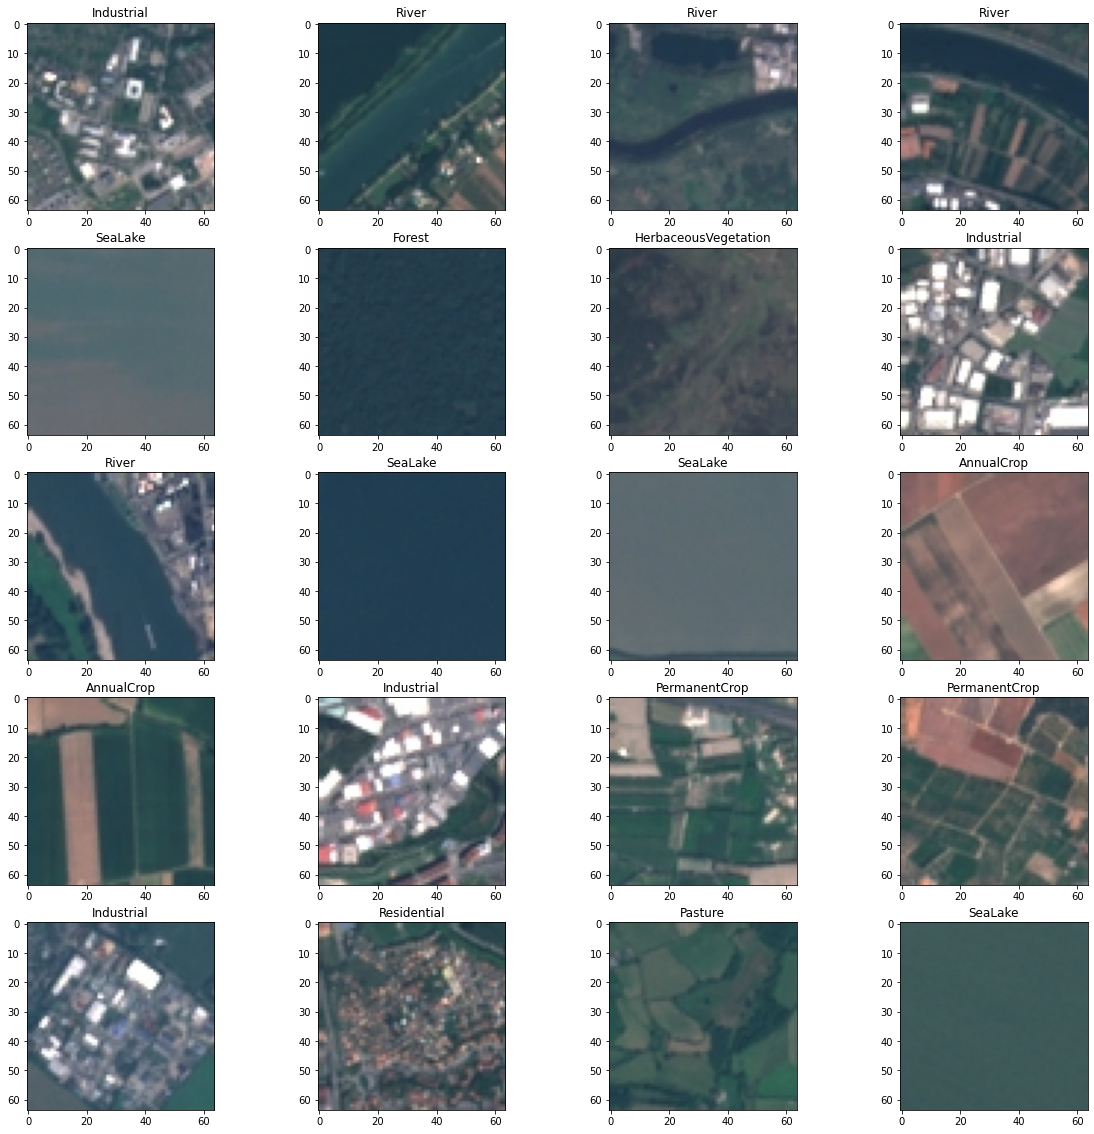

In [ ]:
def preview_dataset(dataset):
    plt.figure(figsize=(20,20))
    plot_index=0
    for features in dataset.take(20):
        (image, label) = features
        plot_index += 1
        plt.subplot(5, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())  #appending label to numpy array
        plt.title( label)
        plt.imshow(image.numpy())
preview_dataset(training_data)

In [ ]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image
#ZOOM
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))


In [ ]:
def augment_data(image,label):
  image=augment_flip(image)
  image=augment_color(image)
  image=augment_inversion(image)
  image=augment_rotation(image)
  image=augment_zoom(image)

  return image,label

In [ ]:
dataset_train_augmented = training_data.map(augment_data)

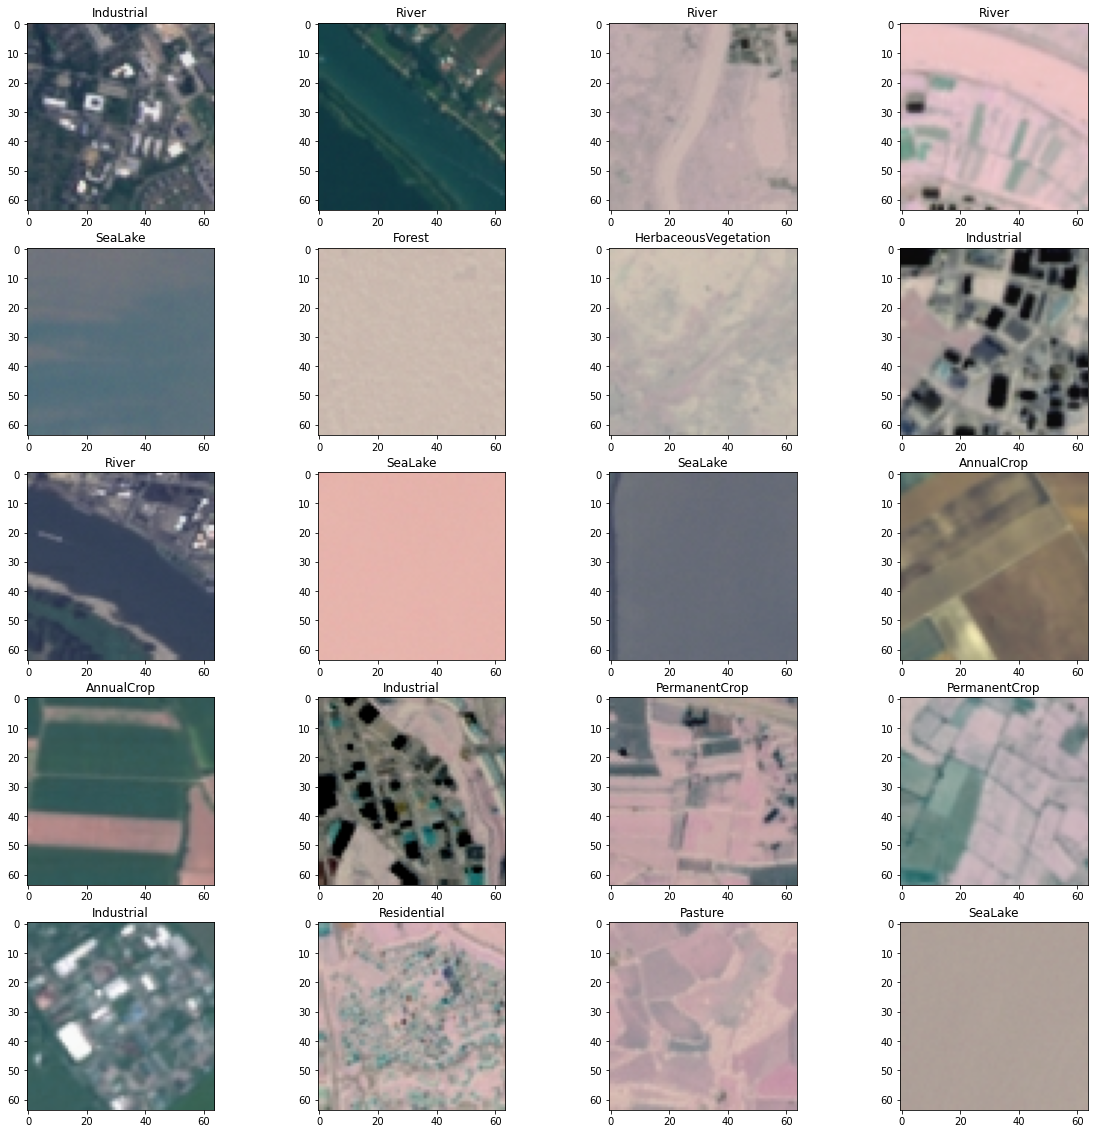

In [ ]:
def preview_dataset(dataset):
    plt.figure(figsize=(20,20))
    plot_index=0
    for features in dataset.take(20):
        (image, label) = features
        plot_index += 1
        plt.subplot(5, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())  #appending label to numpy array
        plt.title( label)
        plt.imshow(image.numpy())
preview_dataset(dataset_train_augmented)

In [ ]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution2D(input_shape=image_shape,filters=32,kernel_size=2,activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1)))
model.add(tf.keras.layers.Convolution2D(filters=32,kernel_size=2,strides=(2,2),activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Convolution2D(filters=64,kernel_size=3,activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1)))
model.add(tf.keras.layers.Convolution2D(filters=128,kernel_size=3,activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(units=512,activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=num_class,activation=tf.keras.activations.softmax))

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 63, 63, 32)        416       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 31, 31, 32)        4128      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 10, 10, 128)     

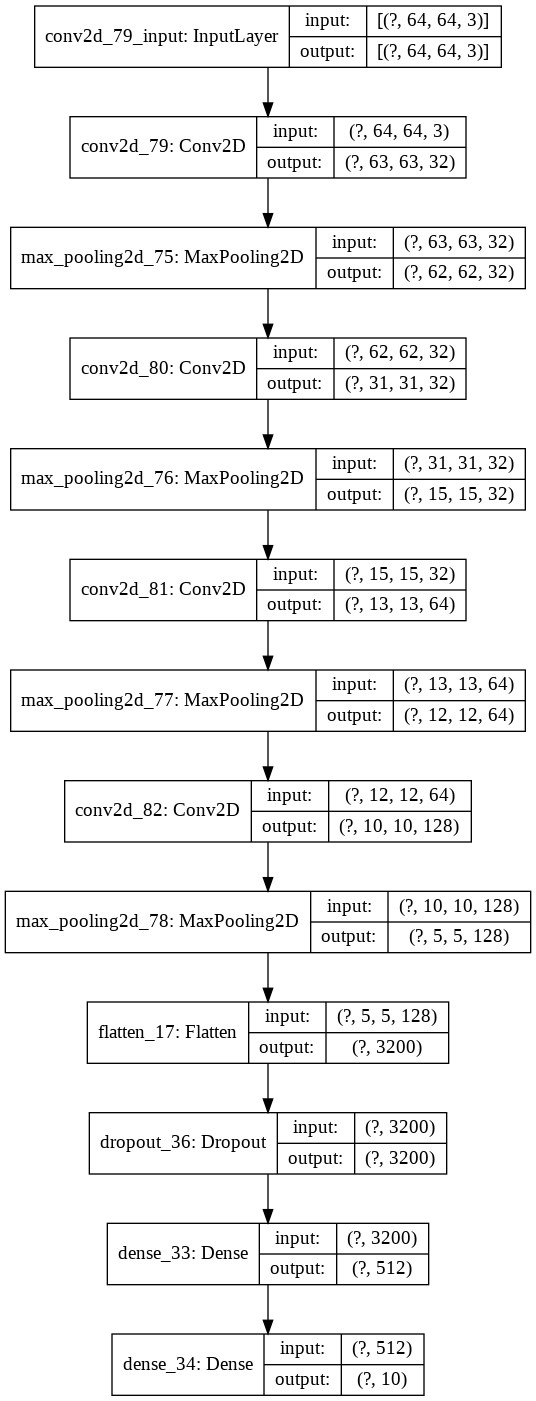

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
BATCH_SIZE = 32

train_batches = dataset_train_augmented.batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_data.batch(BATCH_SIZE).prefetch(1)

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS =30

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
675/675 [==============================] - 26s 39ms/step - loss: 1.9947 - accuracy: 0.4635 - val_loss: 1.9000 - val_accuracy: 0.5596
Epoch 2/30
675/675 [==============================] - 27s 39ms/step - loss: 1.9932 - accuracy: 0.4640 - val_loss: 1.9201 - val_accuracy: 0.5393
Epoch 3/30
675/675 [==============================] - 26s 39ms/step - loss: 1.9767 - accuracy: 0.4814 - val_loss: 1.9350 - val_accuracy: 0.5237
Epoch 4/30
675/675 [==============================] - 26s 39ms/step - loss: 1.9629 - accuracy: 0.4956 - val_loss: 1.9831 - val_accuracy: 0.4744
Epoch 5/30
675/675 [==============================] - 27s 40ms/step - loss: 1.9938 - accuracy: 0.4648 - val_loss: 2.0876 - val_accuracy: 0.3715
Epoch 6/30
675/675 [==============================] - 26s 38ms/step - loss: 1.9693 - accuracy: 0.4883 - val_loss: 1.9282 - val_accuracy: 0.5319
Epoch 7/30
675/675 [==============================] - 26s 39ms/step - loss: 1.9775 - accuracy: 0.4808 - val_loss: 1.9723 - val_accuracy:

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

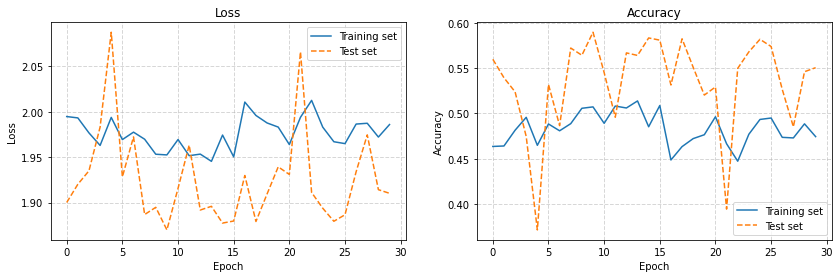

In [ ]:
render_training_history(history)

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(64,64))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
from google.colab import files
image = files.upload()

Saving forset.jpg to forset.jpg
Saving residential.jpg to residential.jpg


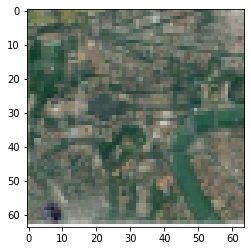

In [ ]:
my_image=plt.imread('residential.jpg')
from skimage.transform import resize
my_image_resized = resize(my_image, (64,64,3))
img = plt.imshow(my_image_resized)

In [ ]:
probabilities = model.predict(np.array( [my_image_resized,] ))
probabilities

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
number_to_class = ['AnnualCrop','Forest',
'HerbaceousVegetation',
'Highway',
'Industrial',
'Pasture',
'PermanentCrop',
'Residential',
'River',
'SeaLake']
index = np.argsort(probabilities[0,:])
print("Most likely class:", number_to_class[index[9]], "-- Probability:", probabilities[0,index[9]])
print("Second most likely class:", number_to_class[index[8]], "-- Probability:", probabilities[0,index[8]])
print("Third most likely class:", number_to_class[index[7]], "-- Probability:", probabilities[0,index[7]])
print("Fourth most likely class:", number_to_class[index[6]], "-- Probability:", probabilities[0,index[6]])
print("Fifth most likely class:", number_to_class[index[5]], "-- Probability:", probabilities[0,index[5]])
print("Sixth most likely class:", number_to_class[index[4]], "-- Probability:", probabilities[0,index[4]])
print("Seventh most likely class:", number_to_class[index[3]], "-- Probability:", probabilities[0,index[3]])
print("Eigth most likely class:", number_to_class[index[2]], "-- Probability:", probabilities[0,index[2]])
print("Ninth most likely class:", number_to_class[index[1]], "-- Probability:", probabilities[0,index[1]])
print("Tenth most likely class:", number_to_class[index[0]], "-- Probability:", probabilities[0,index[0]])

Most likely class: Residential -- Probability: 1.0
Second most likely class: SeaLake -- Probability: 0.0
Third most likely class: River -- Probability: 0.0
Fourth most likely class: PermanentCrop -- Probability: 0.0
Fifth most likely class: Pasture -- Probability: 0.0
Sixth most likely class: Industrial -- Probability: 0.0
Seventh most likely class: Highway -- Probability: 0.0
Eigth most likely class: HerbaceousVegetation -- Probability: 0.0
Ninth most likely class: Forest -- Probability: 0.0
Tenth most likely class: AnnualCrop -- Probability: 0.0
